In [132]:

import os
import json
import nltk
import random
import community.community_louvain as community_louvain  
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sys


# Add the src/ folder to Python path

from pathlib import Path
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from functions import *

PROJECT_ROOT = Path().resolve()          # this should be 02807-project
SRC_DIR = PROJECT_ROOT / "src"
sys.path.append(str(SRC_DIR))

from apriori import generate_rules  # or whatever is inside apriori.py

SEED = 1337

os.environ["PYTHONHASHSEED"] = str(SEED)  # helps across fresh Python runs
random.seed(SEED)
np.random.seed(SEED)

rng = np.random.default_rng(SEED)  # use this instead of np.random directly



In [133]:
# run data.py

# run functions.py

# add python script of the cleaning of the reviews and busnees .py

In [134]:
# Define base directory
DATA_DIR_RAW = Path("data/raw")
DATA_DIR_PROC = Path("data/processed")

# Define file paths
USERS   = DATA_DIR_RAW / "user.json"
REVIEWS = DATA_DIR_RAW / "review.json"
REVIEWS_CLEAN = DATA_DIR_RAW / "review_clean.ndjson"
BIZ     = DATA_DIR_RAW / "business.json"

# categories of restaurants
FOOD = DATA_DIR_RAW / "Food.txt"
RESTAURANTS = DATA_DIR_RAW / "restaurants.txt"


#USERS_FILTERED = DATA_DIR_PROC / "yelp_filtered_user_ids.csv"

#special_ids = set(pd.read_csv(USERS_FILTERED)["user_id"].astype(str))




In [135]:
with open(USERS, 'r') as f:
    user_counts = Counter(json.loads(line)['user_id'] for line in f)


In [136]:
# number of unique users
num_unique_users = len(user_counts)
print(f'Number of unique users: {num_unique_users}')

Number of unique users: 1987897


In [137]:
# create graph
G = nx.Graph()
G.add_nodes_from(user_counts.keys())
with open(USERS, 'r') as f:
    for line in f:
        user = json.loads(line)
        user_id = user['user_id']
        friends = user['friends'].split(', ') if user['friends'] != 'None' else []
        for friend in friends:
            if friend in user_counts:
                G.add_edge(user_id, friend)

In [138]:
degrees = [G.degree(node) for node in G.nodes()]
sorted(degrees)
no_friends = sum(count == 0 for count in degrees)
print(f'Number of users with no friends in the network: {no_friends}')

Number of users with no friends in the network: 1081718


In [139]:
number_of_nodes_full_network = G.number_of_nodes()
number_of_edges_full_network = G.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 1987897
Number of edges in the graph: 7305874


Because we have so many single nodes, we'd rather look at the greatest component in the network, thus filtering out the nodes not connected to any and smaller subgraphs.

In [140]:
# taking the greatest component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])

In [141]:
number_of_nodes_greatest_component = G.number_of_nodes()
number_of_edges_greatest_component = G.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_greatest_component}')
print(f'Number of edges in the graph: {number_of_edges_greatest_component}')

Number of nodes in the graph: 892152
Number of edges in the graph: 7298492


In [142]:
removed_nodes = number_of_nodes_full_network-number_of_nodes_greatest_component
print(f'Number of nodes filtered away is {number_of_nodes_full_network-number_of_nodes_greatest_component}, where {removed_nodes-no_friends} had at least one friend, but were not connected to the greatest component')

Number of nodes filtered away is 1095745, where 14027 had at least one friend, but were not connected to the greatest component


In [143]:
removed_edges = number_of_edges_full_network-number_of_edges_greatest_component
print(f'Number of edges filtered away is {removed_edges}')

Number of edges filtered away is 7382


We can see that even though we filtered more than half of the edges away by only looking at the greatest component, we kept far most of the edges. From that, we know that many of the users with little to know friends were thinly connected together in small subgraphs.

In [144]:
# print degree stats
degrees_GC = [G.degree(node) for node in G.nodes()]
print(f'Average degree: {sum(degrees_GC)/G.number_of_nodes()}')
print(f'Highest degree: {max(degrees_GC)}')
print(f'Lowest degree: {min(degrees_GC)}')

Average degree: 16.361543772810016
Highest degree: 6868
Lowest degree: 1


Although we have drastically cut down on the graph by only keeping the greatest component, it is still way too large to plot, thus we take 5000 random nodes and plot them just to get some visual 

In [145]:
# select 20000 random nodes
random.seed(SEED)
sampled_nodes = random.sample(list(G.nodes()), 30000)
H = G.subgraph(sampled_nodes).copy()


In [146]:
number_of_nodes_full_network = H.number_of_nodes()
number_of_edges_full_network = H.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 30000
Number of edges in the graph: 7411


In [147]:
# taking the greatest component
Hcc = sorted(nx.connected_components(G=H), key=len, reverse=True)
H = H.subgraph(Hcc[0])

In [148]:
number_of_nodes_full_network = H.number_of_nodes()
number_of_edges_full_network = H.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 3350
Number of edges in the graph: 4558


In [149]:
degrees_HC = [H.degree(node) for node in H.nodes()]
print(f'Average degree: {sum(degrees_HC)/H.number_of_nodes()}')
print(f'Highest degree: {max(degrees_HC)}')
print(f'Lowest degree: {min(degrees_HC)}')

Average degree: 2.7211940298507464
Highest degree: 101
Lowest degree: 1


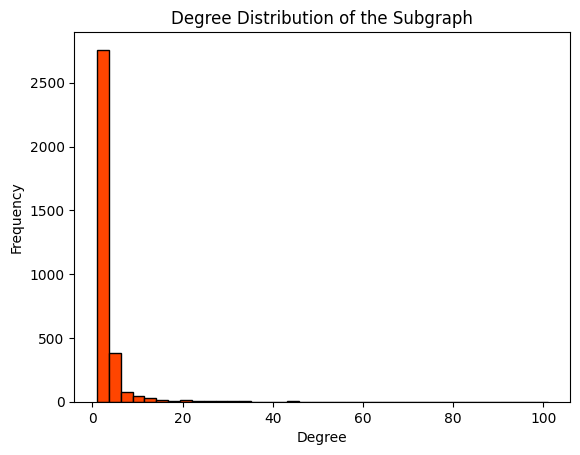

In [150]:
# plot the degree distribution in a histogram
plt.hist(degrees_HC, bins=38, color='orangered', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Subgraph')
plt.savefig("figures/yelp_user_friendship_degree_distribution_subgraph.svg", dpi=300)
plt.show()

Highly skewed degree distribution, with many nodes not having many friends.

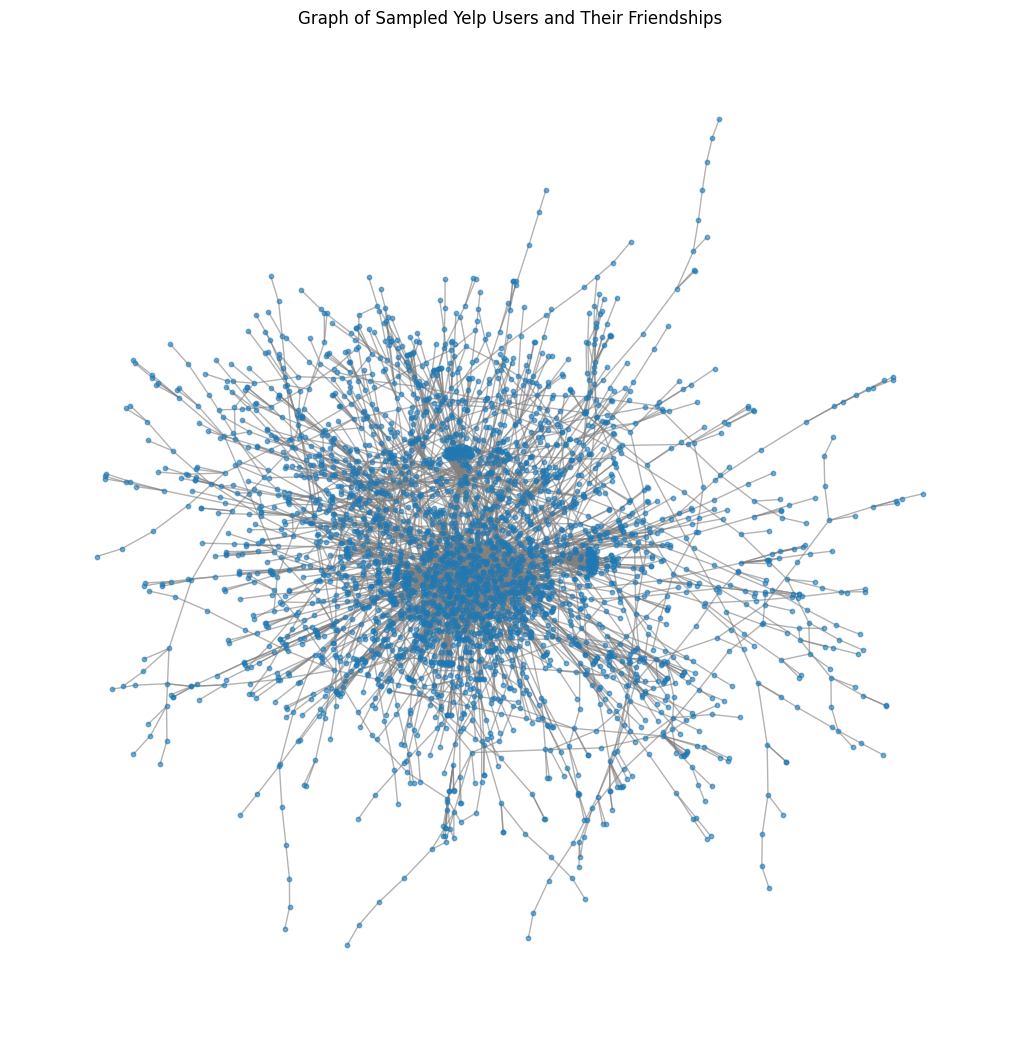

In [151]:
plt.figure(figsize=(10, 10))
nx.draw(H, node_size=10, alpha=0.6, edge_color="gray", with_labels=False)
plt.title("Graph of Sampled Yelp Users and Their Friendships")
plt.savefig("figures/yelp_user_friendship_graph.svg", dpi=300)
plt.show()

In [152]:
graph_dict = nx.to_dict_of_lists(H)

In [153]:
sorted_betweenness = sorted(betweenness_centrality_normalized(graph_dict).items(), key=lambda x: x[1], reverse=True)
print("Top 10 users by betweenness centrality:")
for user, centrality in sorted_betweenness[:10]:
    print(f'User ID: {user}, Betweenness Centrality: {centrality}')

sorted_betweenness = dict(sorted_betweenness)

Top 10 users by betweenness centrality:
User ID: kTpsjDUhl9BlRl0FVuNreA, Betweenness Centrality: 0.19121376799555106
User ID: nxWrhF_hyX0wwjrEkQX8uQ, Betweenness Centrality: 0.19104607415843197
User ID: 5tXRxr4T24Awl7vjyCvIcQ, Betweenness Centrality: 0.1532429155781057
User ID: n4Y6wdh6om3QtIFlWakfDQ, Betweenness Centrality: 0.11868091115148598
User ID: LkXNQQaIc5yrKu9Ap87RrA, Betweenness Centrality: 0.10304769880858845
User ID: 1pzP58PeWictHQzctMU0nQ, Betweenness Centrality: 0.09445696369665639
User ID: VfHM5XFUavrMVqncH43pCQ, Betweenness Centrality: 0.08279168738116952
User ID: UvpSUxJk8Ai9XHbDgi5YqQ, Betweenness Centrality: 0.07732308401359089
User ID: cpP1KtEYiTHA2pdpSkLIpQ, Betweenness Centrality: 0.07620530888287017
User ID: 4Xq6wZztTQGbO06EyrpCFQ, Betweenness Centrality: 0.07567860280050154


In [154]:
# Comparing to the built-in function
"""
betweenness_centrality_built_in = nx.betweenness_centrality(H)
sorted_betweenness_built_in = sorted(betweenness_centrality_built_in.items(), key=lambda x: x[1], reverse=True)
print("Top 10 users by betweenness centrality (built-in):")
for user, centrality in sorted_betweenness_built_in[:10]:
    print(f'User ID: {user}, Betweenness Centrality: {centrality}')
"""

'\nbetweenness_centrality_built_in = nx.betweenness_centrality(H)\nsorted_betweenness_built_in = sorted(betweenness_centrality_built_in.items(), key=lambda x: x[1], reverse=True)\nprint("Top 10 users by betweenness centrality (built-in):")\nfor user, centrality in sorted_betweenness_built_in[:10]:\n    print(f\'User ID: {user}, Betweenness Centrality: {centrality}\')\n'

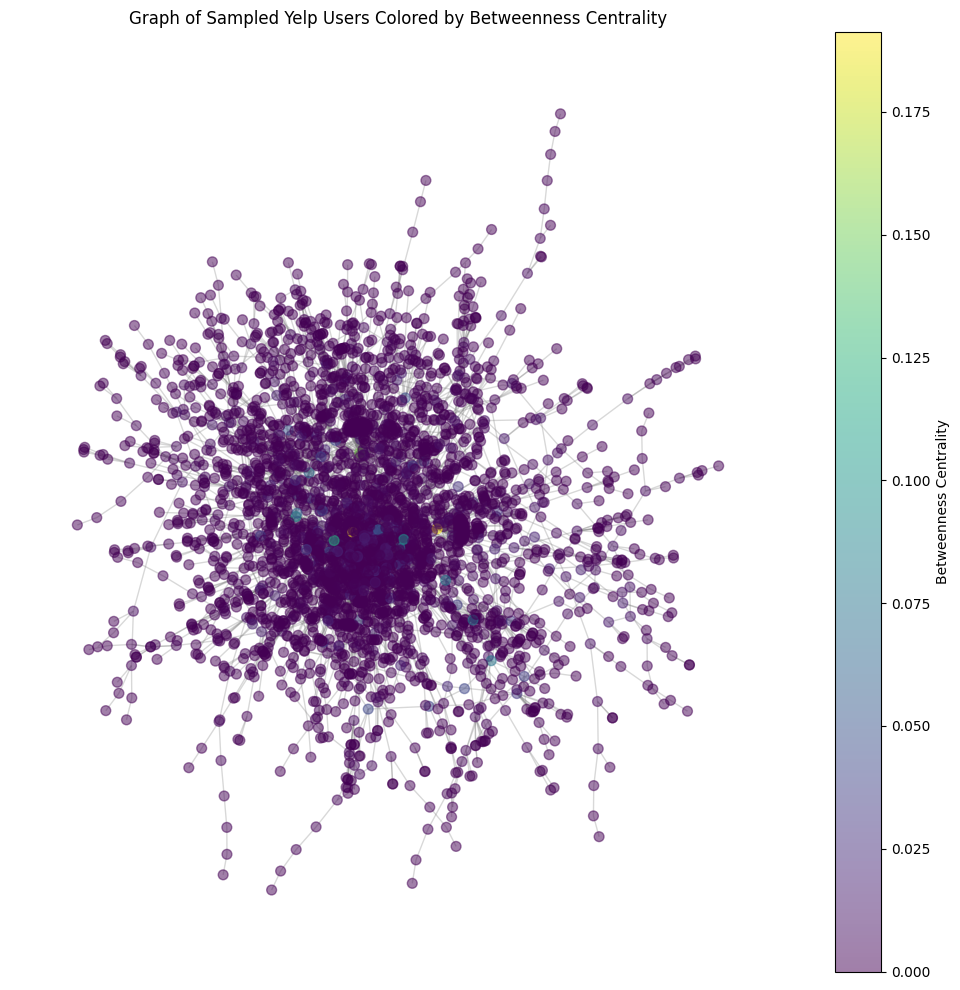

In [155]:
# Change to the manual calculation
node_colors = [sorted_betweenness[n] for n in H.nodes()]

pos = nx.spring_layout(H, seed=SEED)

fig, ax = plt.subplots(figsize=(10, 10))

nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    node_size=50,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.5
)
nx.draw_networkx_edges(H, pos, ax=ax, edge_color="gray", alpha=0.3)

ax.set_title("Graph of Sampled Yelp Users Colored by Betweenness Centrality")
ax.set_axis_off()

cbar = fig.colorbar(nodes, ax=ax)
cbar.set_label("Betweenness Centrality")

plt.tight_layout()
plt.savefig("figures/yelp_user_friendship_betweenness_centrality.svg", dpi=300)
plt.show()

In [ ]:
mods = {}
for k in range(30, 50):
    labels = spectral_clustering(graph_dict, k)
    communities = {}
    for node, lbl in labels.items():
        communities.setdefault(lbl, []).append(node)
    mods[k] = nx.algorithms.community.quality.modularity(H, communities.values())

print(mods)
print("Optimal number of clusters (k) based on highest modularity:", max(mods, key=mods.get))

{10: 0.39756824477299163, 11: 0.39788460505433254, 12: 0.39987812006567, 13: 0.4005022005871953, 14: 0.41120093010163367, 15: 0.4115881676008179, 16: 0.40708316831416275, 17: 0.4123707531670684, 18: 0.40336900956344257, 19: 0.4178226672707154, 20: 0.4170085780446494, 21: 0.4184763020277285, 22: 0.4132033258237978, 23: 0.4193474058986402, 24: 0.4215983652560793, 25: 0.41301331711925726, 26: 0.4239964459828477, 27: 0.43291094683106385, 28: 0.43147212727536327, 29: 0.43338188924150745, 30: 0.43727772952618305, 31: 0.4348580847969741, 32: 0.4355895761922632, 33: 0.4347808298328732, 34: 0.47248890560954787, 35: 0.461750922871917, 36: 0.45528850902443896, 37: 0.46910997564230417, 38: 0.4793669559772817, 39: 0.4729427604734147, 40: 0.4987942208858532, 41: 0.4755586231846528, 42: 0.45464435665242753, 43: 0.4674349628723715, 44: 0.4593536122880929, 45: 0.4739825497160965, 46: 0.4826102926523935, 47: 0.48297878198427724, 48: 0.47202395587388984, 49: 0.5072266363179004}
Optimal number of clusters

In [156]:
# to be able to recreate same graph with community detection
H = nx.Graph(H)
H = nx.relabel_nodes(H, dict(zip(sorted(H.nodes()), sorted(H.nodes()))))

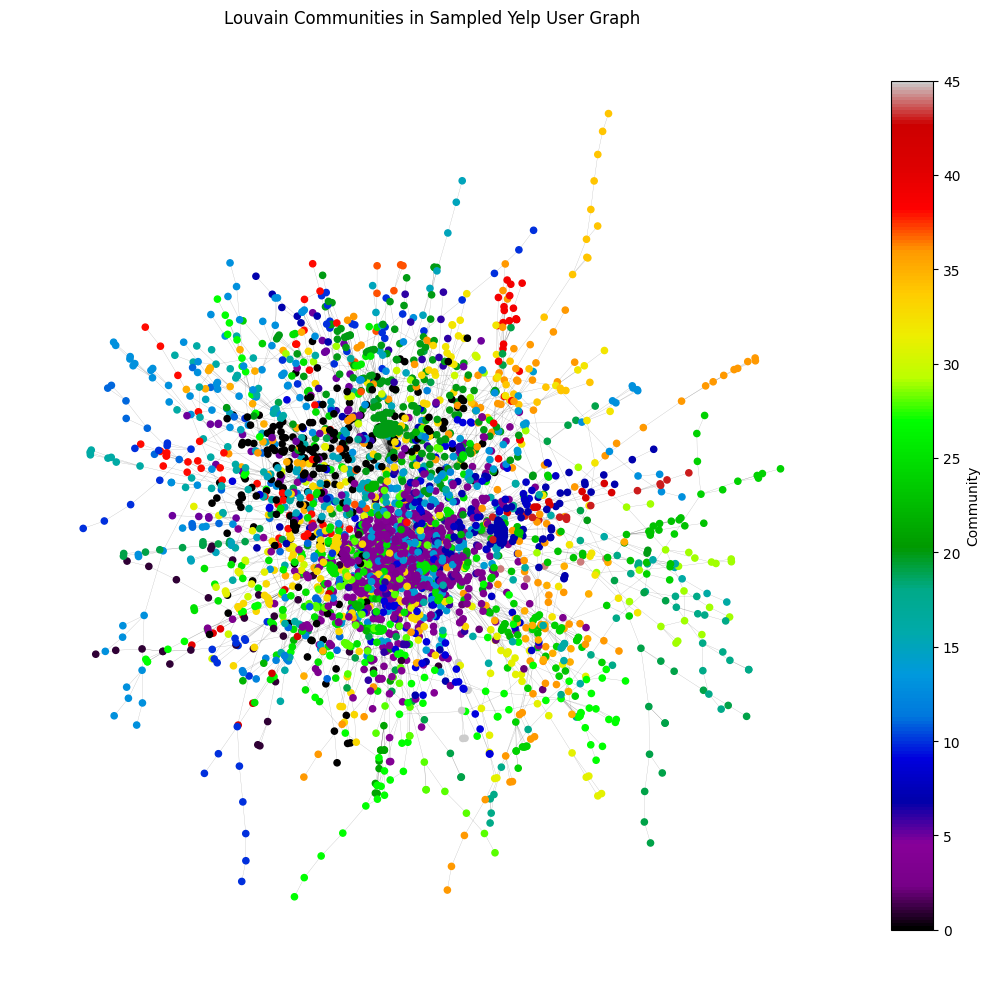

In [ ]:
# Louvain partition
partition = community_louvain.best_partition(H, random_state=SEED)

# Map community labels
com_ids = {c: i for i, c in enumerate(sorted(set(partition.values())))}
node_colors = [com_ids[partition[n]] for n in H.nodes()]
num_comms = len(com_ids)

pos = nx.spring_layout(H, seed=SEED)

fig, ax = plt.subplots(figsize=(10, 10))
nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    nodelist=list(H.nodes()),
    node_size=20,
    node_color=node_colors,
    cmap=plt.cm.tab20 if num_comms <= 20 else plt.cm.viridis
)
nx.draw_networkx_edges(H, pos, ax=ax, alpha=0.3, width=0.2)

# Colormap for better distinction between communities
nodes.set_cmap(plt.cm.tab20b if num_comms <= 20 else plt.cm.nipy_spectral)
ax.set_title("Louvain Communities in Sampled Yelp User Graph")
ax.set_axis_off()

cbar = fig.colorbar(nodes, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Community")
if num_comms <= 20:
    cbar.set_ticks(range(num_comms))
    cbar.set_ticklabels(range(num_comms))

plt.tight_layout()
plt.savefig("figures/yelp_user_friendship_louvain_communities.svg", dpi=300)
plt.show()


In [158]:
sizes = pd.Series(list(partition.values())).value_counts()
print(sizes)


3     332
4     293
20    242
0     218
25    167
7     149
33    140
14    130
36    124
16    116
13    112
27     95
15     82
28     75
9      73
19     64
24     63
6      63
31     62
23     59
35     57
22     55
10     55
38     50
12     47
5      40
32     37
11     37
1      35
8      34
18     33
29     31
34     26
39     25
30     24
26     22
43     15
37     13
21     12
41     10
17      7
45      6
40      5
42      5
44      5
2       5
Name: count, dtype: int64


In [159]:
# user_ids in community 6
users_in_community_6 = [node for node, comm in partition.items() if comm == 6]
print(f'User IDs in community 6: {users_in_community_6}')

User IDs in community 6: ['9s-bJjqIzeXqEokQc4fUxA', 'Hj-o_dC-5mZSm_phjnJ9tw', 'pn2Y9udA1C9Ox1RAPP8zxg', 'DU2ysoceoDcuuNg56y7MYg', 'JnW0--jJ8Xcg0sJ19TCezg', 'x5Ls8KSbhzwWj05frOp81w', 'RL63KkoMwq-ex-WWpzgvcg', 'lByMP4tkeruOw5HdjtXTpQ', 'WYMPfeEGMlc46BrRYfOOIw', '53q4TlQToaakkwW6xZLWGA', 'Ri56LpAkSpFEfHJF71gzBw', 'YM6Z2255UgCwKKskfIrP_A', 'OCaGBM34mlJYAEP0N1rpAw', 'kjHhS99jT85UydTWKg4ELA', 'qZeX1ZZkN7DXk10keuGOhg', 'gPh8rpoOq2hjyhF2pAdn2A', 'PMhBMIpAH_wf0aAe2OOIFg', 'k990q7i4Mk7MbmfNCjMxbQ', 'peed4TaAganxrMjRQAbnXw', 'VX39EqGezrKZXOQh7BmH7w', 'z5EsE_98gW2Ec1encum7eA', 'Rd3ERzHRzjoexJjBgO_bRw', 'vetI1F4btXdQAe5G2A2ciA', 'hRpqHQheV455Dc0z7pIsxA', 'AVfwXXqM9KOi_rZ_ALxxoQ', 'yROH68ur31AmT04scG24mg', '-dbM944bfCz-KeUD5gTErw', 'BwpJ_b_cUX4XB71J4wm3qA', 'l-oUhunGD1BTcHbNdQkpbw', 'st_IkWLhb3unxU2ym4eWDw', 'YSyP5E36KQkm62LmTvM4kw', 'E46WAwYoVXkmrVAi5azg7A', 'AceFqyqnDoHCY-ANsrFZVQ', '2qFAfdzMEVzbDZftdiJK4g', 'kGJg_kMhn1RjgqIJPJr_VA', 'MkftI7O_YvZpj0ieTmv5LQ', 'ny3Y1mlW6Zz_6JH8ATWyRA', 'Q8jqWq4I88q

In [160]:
import networkx as nx
from networkx.algorithms.community import modularity

comms = {}
for n,c in partition.items():
    comms.setdefault(c, []).append(n)

modularity_score = modularity(H, comms.values())
print(modularity_score)

0.8195781070310008


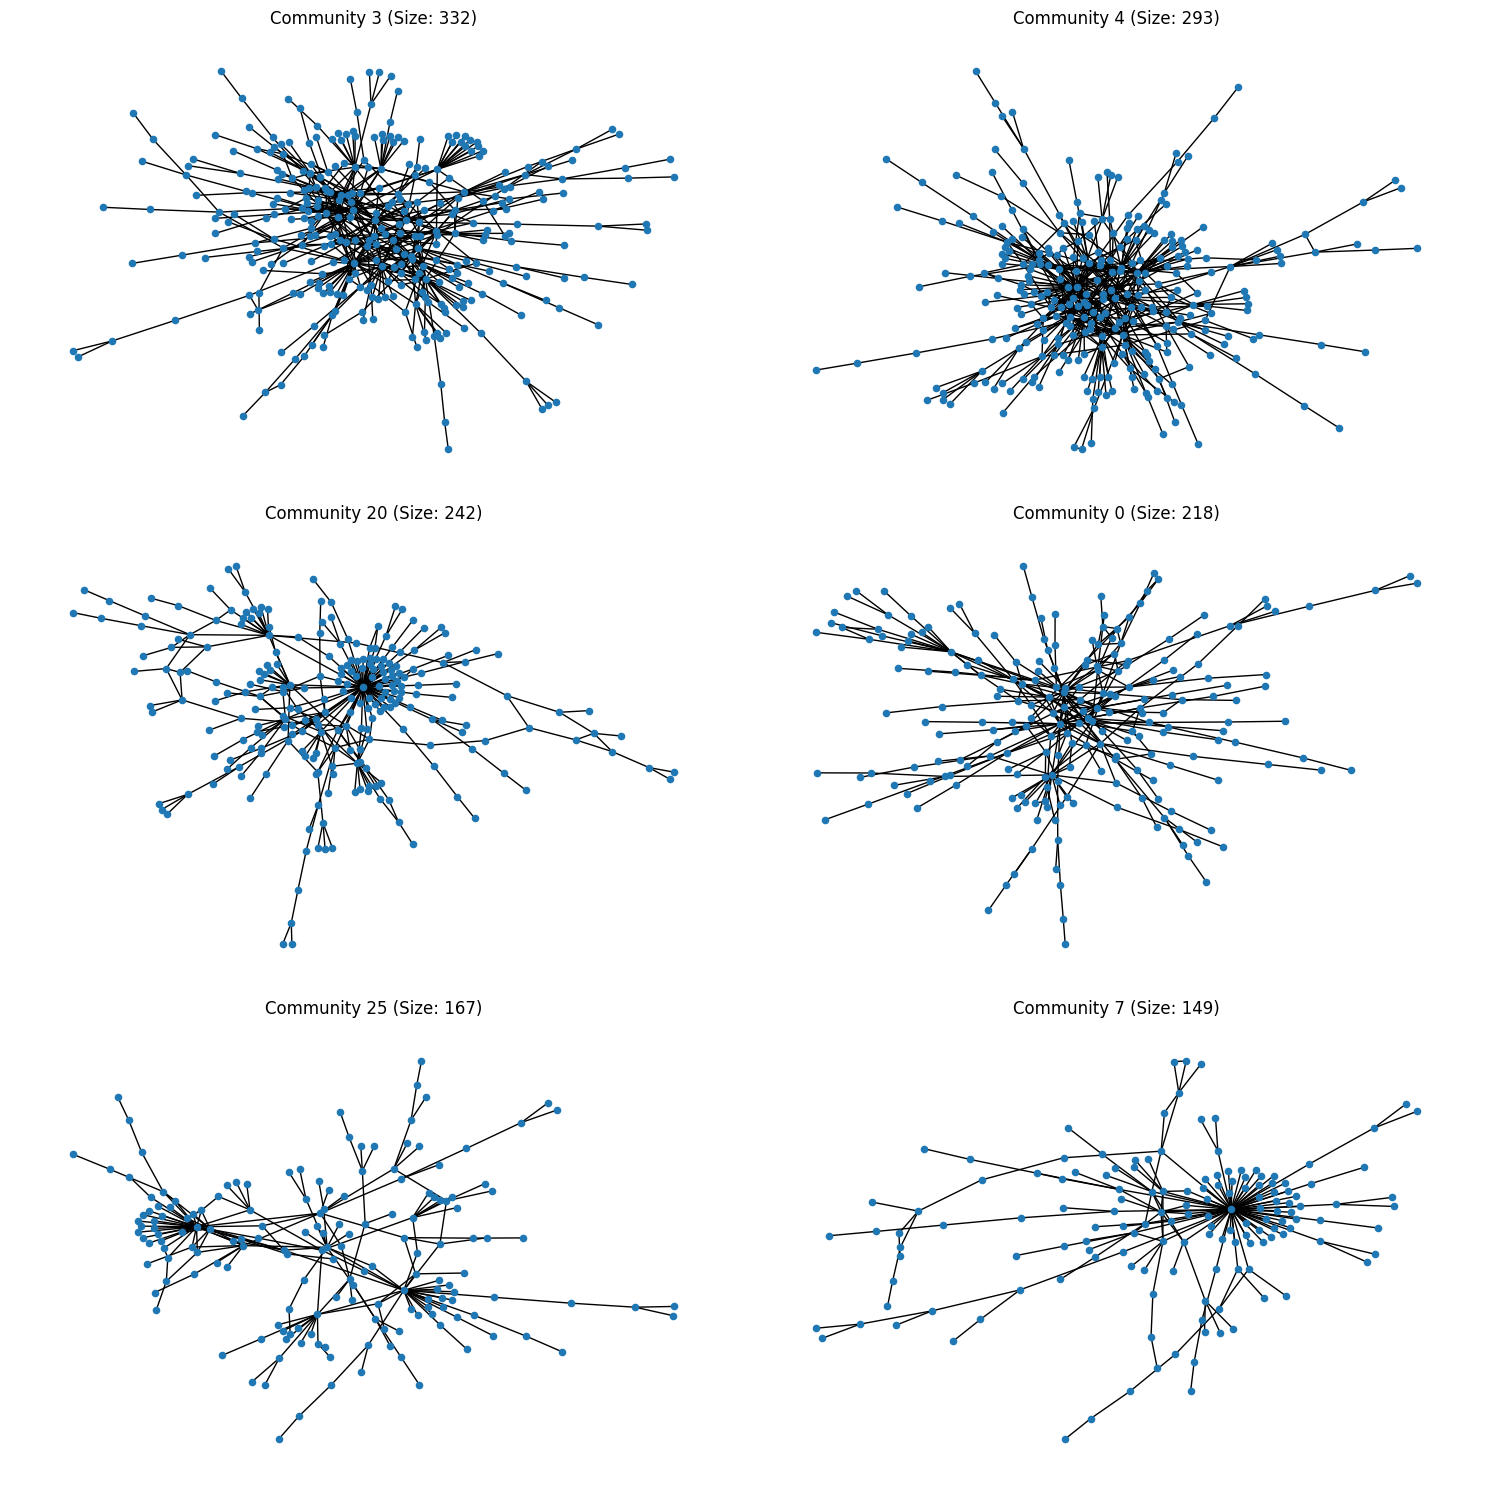

In [161]:
top_6_communities = sizes.index[:6]

plt.figure(figsize=(15, 15))
for i, community in enumerate(top_6_communities, 1):
    nodes = [n for n, c in partition.items() if c == community]
    sub = H.subgraph(nodes)
    plt.subplot(3, 2, i)
    nx.draw(sub, with_labels=False, node_size=20)
    plt.title(f'Community {community} (Size: {sizes[community]})')

plt.tight_layout()
plt.savefig("figures/yelp_user_friendship_top6_communities.svg", dpi=300)
plt.show()


In [162]:
user_community_df = pd.DataFrame(
    [(node, comm) for node, comm in partition.items()],
    columns=["user_id", "community"]
)

# save as csv
user_community_df.to_csv(DATA_DIR_PROC / "yelp_user_communities.csv", index=False)

### Apriori on the communities